In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [2]:
data_dir = '/data/home/alkhaldieid/repos/daily_classifier/dataset/'
img_size = 224
batch_size = 32
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load all data
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Classes: ['civil', 'cleaning', 'electric', 'garden', 'hvac', 'mech']


In [5]:
print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

# Check class distribution (optional)
from collections import Counter
train_labels = [full_dataset.targets[i] for i in train_ds.indices]
val_labels = [full_dataset.targets[i] for i in val_ds.indices]
test_labels = [full_dataset.targets[i] for i in test_ds.indices]

print("Train class counts:", Counter(train_labels))
print("Val class counts:", Counter(val_labels))
print("Test class counts:", Counter(test_labels))


Total samples: 730
Training samples: 510
Validation samples: 109
Test samples: 111
Train class counts: Counter({1: 191, 2: 101, 3: 95, 0: 52, 4: 39, 5: 32})
Val class counts: Counter({1: 37, 2: 23, 3: 15, 0: 14, 4: 12, 5: 8})
Test class counts: Counter({1: 52, 3: 21, 2: 21, 4: 8, 0: 5, 5: 4})


In [6]:
import torchvision.models as models
import torch.nn as nn

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model = model.to(device)


/home/alkhaldieid/miniforge3/envs/ai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alkhaldieid/miniforge3/envs/ai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/alkhaldieid/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 10.7MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
epochs = 50
for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_running_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/50 | Train Loss: 0.9716, Acc: 0.8392 | Val Loss: 0.9732, Acc: 0.6881
Epoch 2/50 | Train Loss: 0.7316, Acc: 0.8784 | Val Loss: 0.8472, Acc: 0.7339
Epoch 3/50 | Train Loss: 0.5358, Acc: 0.9157 | Val Loss: 0.7357, Acc: 0.7248
Epoch 4/50 | Train Loss: 0.4009, Acc: 0.9353 | Val Loss: 0.6816, Acc: 0.7339
Epoch 5/50 | Train Loss: 0.2998, Acc: 0.9608 | Val Loss: 0.6092, Acc: 0.7431
Epoch 6/50 | Train Loss: 0.2295, Acc: 0.9706 | Val Loss: 0.5709, Acc: 0.7798
Epoch 7/50 | Train Loss: 0.1452, Acc: 0.9902 | Val Loss: 0.5567, Acc: 0.8073
Epoch 8/50 | Train Loss: 0.1082, Acc: 0.9941 | Val Loss: 0.5408, Acc: 0.8073
Epoch 9/50 | Train Loss: 0.0863, Acc: 1.0000 | Val Loss: 0.5250, Acc: 0.8349
Epoch 10/50 | Train Loss: 0.0549, Acc: 0.9980 | Val Loss: 0.5347, Acc: 0.8257
Epoch 11/50 | Train Loss: 0.0504, Acc: 0.9922 | Val Loss: 0.5150, Acc: 0.8532
Epoch 12/50 | Train Loss: 0.0314, Acc: 1.0000 | Val Loss: 0.4853, Acc: 0.8624
Epoch 13/50 | Train Loss: 0.0336, Acc: 1.0000 | Val Loss: 0.5309, Acc: 0.

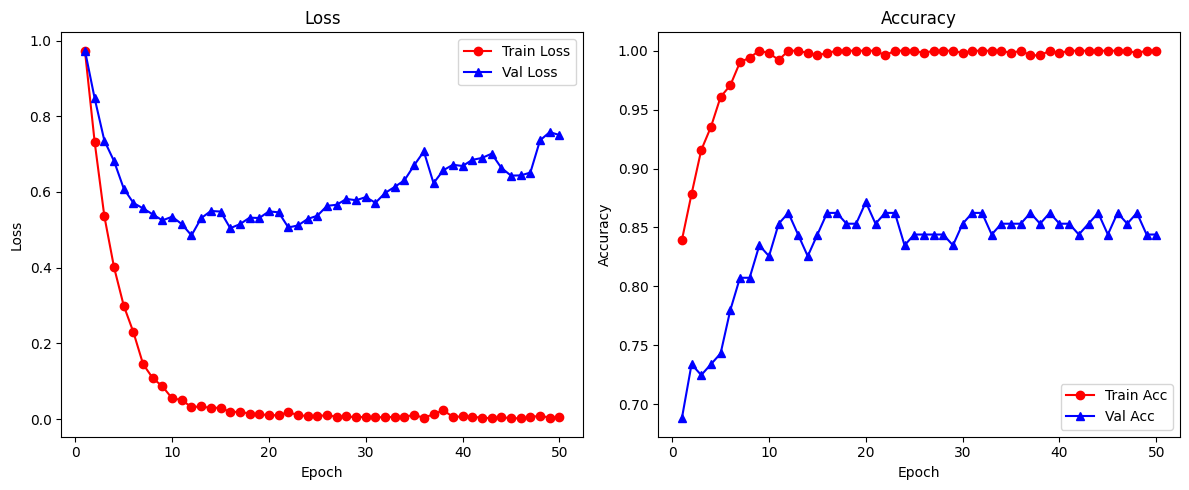

In [11]:
epochs_range = range(1, epochs+1)

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'ro-', label='Train Loss')
plt.plot(epochs_range, val_losses, 'b^-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'ro-', label='Train Acc')
plt.plot(epochs_range, val_accuracies, 'b^-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
